### Test Tabnet on Employee Attrition Data

In [1]:
import pandas as pd
import numpy as np
import ads

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from pytorch_tabnet.metrics import Metric

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from ads.dataset.factory import DatasetFactory

import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [2]:
print(ads.__version__)

2.6.2


In [3]:
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

# uso ancora la classe dataset per fare l'upsampling

ds = DatasetFactory.open(
      attrition_path,
      target="Attrition").set_positive_class('Yes')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# lavoro ancora sul dataset up sampled

ds_up = ds.up_sample()

In [5]:
cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

ds_used = ds_up.drop(columns=cols_to_drop)

In [6]:
TARGET = 'Attrition'

features = list(set(ds_used.columns) - set([TARGET]))

features

['SalaryLevel',
 'EducationalLevel',
 'CommuteLength',
 'OverTime',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'YearsWithCurrManager',
 'MonthlyIncome',
 'RelationshipSatisfaction',
 'WorkLifeBalance',
 'YearsSinceLastPromotion',
 'JobRole',
 'NumCompaniesWorked',
 'HourlyRate',
 'EnvironmentSatisfaction',
 'Gender',
 'EducationField',
 'MonthlyRate',
 'JobLevel',
 'MaritalStatus',
 'Age',
 'JobInvolvement',
 'JobFunction',
 'YearsinIndustry',
 'PerformanceRating',
 'PercentSalaryHike',
 'JobSatisfaction',
 'YearsAtCurrentLevel',
 'YearsOnJob',
 'TravelForWork']

In [8]:
# take the Pandas DataFRame out

# versione differente di ADS (2.0... il metodo ha altro nome)
df_used = ds_used.to_pandas()

### lavorando direttamente senza AutoML dobbiamo provvedere noi a tutta la data preparation

In [9]:
THR = 10

nunique = df_used.nunique()
types = df_used.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df_used.columns:
    
    # identifichiamo come categoriche tutte le colonne che soddisfano questa condizione !!!
    # la soglia la possiamo cambiare
    if types[col] == 'object' or nunique[col] < THR:
        print(col, df_used[col].nunique())
        
        # codifichiamo i categorici con LabelEncoder
        l_enc = LabelEncoder()
        df_used[col] = l_enc.fit_transform(df_used[col].values)
        
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

TravelForWork 3
JobFunction 3
EducationalLevel 5
EducationField 6
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
OverTime 2
PerformanceRating 2
RelationshipSatisfaction 4
StockOptionLevel 4
TrainingTimesLastYear 7
WorkLifeBalance 4
Attrition 2


In [10]:
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [11]:
# now we have codified everything, are ready

In [12]:
X = df_used[features].values
y = df_used[TARGET].values

X.shape

(2466, 30)

In [13]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 1234)

print("# of samples in train set", X_train.shape[0])
print("# of samples in test set", X_test.shape[0])

# of samples in train set 1972
# of samples in test set 494


In [14]:
#
# if we need F we need a custom implementation for F1 in Tabnet
#
class F1(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
        # potremmo lavorare siu questa soglia
        self.thr = 0.55
    
    # the input are probs, must be converted to 0, 1
    def __call__(self, y_true, p_score):
        
        # here we have labels
        y_score = (p_score[:, 1] >= self.thr).astype(int)
        
        return f1_score(y_true, y_score)

In [15]:
%%time
# see: https://github.com/dreamquark-ai/tabnet

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_test],
    pretraining_ratio=0.6,
    max_epochs = 200
)

Device used : cpu
epoch 0  | loss: 5.87444 | val_0_unsup_loss: 133.1254|  0:00:00s
epoch 1  | loss: 4.82121 | val_0_unsup_loss: 35.21624|  0:00:00s
epoch 2  | loss: 4.30497 | val_0_unsup_loss: 9.50589 |  0:00:00s
epoch 3  | loss: 3.9544  | val_0_unsup_loss: 5.79228 |  0:00:01s
epoch 4  | loss: 3.67798 | val_0_unsup_loss: 4.60301 |  0:00:01s
epoch 5  | loss: 3.42022 | val_0_unsup_loss: 4.11686 |  0:00:01s
epoch 6  | loss: 3.27431 | val_0_unsup_loss: 3.95514 |  0:00:02s
epoch 7  | loss: 3.12567 | val_0_unsup_loss: 3.76365 |  0:00:02s
epoch 8  | loss: 3.01629 | val_0_unsup_loss: 3.58573 |  0:00:02s
epoch 9  | loss: 2.93043 | val_0_unsup_loss: 3.37127 |  0:00:03s
epoch 10 | loss: 2.84778 | val_0_unsup_loss: 3.07771 |  0:00:03s
epoch 11 | loss: 2.72424 | val_0_unsup_loss: 2.91882 |  0:00:03s
epoch 12 | loss: 2.67555 | val_0_unsup_loss: 2.81065 |  0:00:03s
epoch 13 | loss: 2.60879 | val_0_unsup_loss: 2.73115 |  0:00:04s
epoch 14 | loss: 2.56541 | val_0_unsup_loss: 2.65398 |  0:00:04s
epoch 1

In [16]:
#
# In questo caso ho preferito utilizzare direttamente Optuna (su cui è basato ADSTuner)
#

# split in due parti la seconda ottimizzo con Optuna

# la valutazione la facciamo sull'accuracy

def objective(trial):
    n_steps = trial.suggest_int("n_steps", 1, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    
    params = {
        "cat_idxs" : cat_idxs,
        "cat_dims" : cat_dims,
        "n_steps" : n_steps,
        "gamma" : gamma,
        "seed" : 0,
        "verbose" : 10
    }
    clf = TabNetClassifier(**params)

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['auc', 'accuracy'],
        from_unsupervised=unsupervised_model,
        batch_size=128, 
        max_epochs = 100
    )
    
    y_pred = clf.predict(X_test)
    
    return round(accuracy_score(y_test, y_pred), 5)

In [17]:
#
# cre<te an launch the study
#
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)

[I 2022-07-04 15:59:13,108] A new study created in memory with name: no-name-54c941b0-02f2-4699-a0be-47be4eccdaa8


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90443 | train_auc: 0.67825 | train_accuracy: 0.61359 | valid_auc: 0.68993 | valid_accuracy: 0.59717 |  0:00:00s
epoch 10 | loss: 0.21839 | train_auc: 0.9466  | train_accuracy: 0.82404 | valid_auc: 0.89194 | valid_accuracy: 0.77126 |  0:00:08s
epoch 20 | loss: 0.14445 | train_auc: 0.99363 | train_accuracy: 0.964   | valid_auc: 0.95676 | valid_accuracy: 0.91903 |  0:00:14s
epoch 30 | loss: 0.11199 | train_auc: 0.99876 | train_accuracy: 0.98529 | valid_auc: 0.95632 | valid_accuracy: 0.9251  |  0:00:20s


[I 2022-07-04 15:59:34,376] Trial 0 finished with value: 0.9251 and parameters: {'n_steps': 2, 'gamma': 1.870786850654723}. Best is trial 0 with value: 0.9251.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.9251
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90632 | train_auc: 0.66376 | train_accuracy: 0.59584 | valid_auc: 0.67596 | valid_accuracy: 0.61538 |  0:00:00s
epoch 10 | loss: 0.27623 | train_auc: 0.94124 | train_accuracy: 0.81085 | valid_auc: 0.88417 | valid_accuracy: 0.78543 |  0:00:06s
epoch 20 | loss: 0.14925 | train_auc: 0.98857 | train_accuracy: 0.94777 | valid_auc: 0.93535 | valid_accuracy: 0.86235 |  0:00:12s
epoch 30 | loss: 0.10674 | train_auc: 0.9959  | train_accuracy: 0.97312 | valid_auc: 0.94977 | valid_accuracy: 0.90081 |  0:00:18s


[I 2022-07-04 15:59:56,745] Trial 1 finished with value: 0.91903 and parameters: {'n_steps': 1, 'gamma': 1.7668838877066828}. Best is trial 0 with value: 0.9251.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.91903
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90788 | train_auc: 0.58699 | train_accuracy: 0.54108 | valid_auc: 0.58006 | valid_accuracy: 0.53239 |  0:00:00s
epoch 10 | loss: 0.27796 | train_auc: 0.96459 | train_accuracy: 0.85091 | valid_auc: 0.9282  | valid_accuracy: 0.80364 |  0:00:06s
epoch 20 | loss: 0.13747 | train_auc: 0.9941  | train_accuracy: 0.9645  | valid_auc: 0.97138 | valid_accuracy: 0.91498 |  0:00:12s
epoch 30 | loss: 0.08893 | train_auc: 0.99884 | train_accuracy: 0.98479 | valid_auc: 0.97034 | valid_accuracy: 0.9251  |  0:00:19s
epoch 40 | loss: 0.10595 | train_auc: 0.99826 | train_accuracy: 0.98327 | valid_auc: 0.96811 | valid_accuracy: 0.91093 |  0:00:25s


[I 2022-07-04 16:00:25,505] Trial 2 finished with value: 0.94737 and parameters: {'n_steps': 6, 'gamma': 1.6392899577547018}. Best is trial 2 with value: 0.94737.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.94737
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90683 | train_auc: 0.63495 | train_accuracy: 0.59635 | valid_auc: 0.65955 | valid_accuracy: 0.61538 |  0:00:00s
epoch 10 | loss: 0.23664 | train_auc: 0.92879 | train_accuracy: 0.83671 | valid_auc: 0.89742 | valid_accuracy: 0.80972 |  0:00:06s
epoch 20 | loss: 0.17715 | train_auc: 0.98828 | train_accuracy: 0.9503  | valid_auc: 0.94549 | valid_accuracy: 0.89069 |  0:00:12s
epoch 30 | loss: 0.09946 | train_auc: 0.99875 | train_accuracy: 0.98834 | valid_auc: 0.96633 | valid_accuracy: 0.917   |  0:00:18s
epoch 40 | loss: 0.08151 | train_auc: 0.9996  | train_accuracy: 0.98682 | valid_auc: 0.96365 | valid_accuracy: 0.92105 |  0:00:25s

Early stopping occurred at epoch 44 with best_epoch = 34 and best_valid_accuracy = 0.93522
Best weights from best epoch are automatical

[I 2022-07-04 16:00:53,656] Trial 3 finished with value: 0.93522 and parameters: {'n_steps': 2, 'gamma': 1.714969818423346}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.89675 | train_auc: 0.62506 | train_accuracy: 0.55223 | valid_auc: 0.63844 | valid_accuracy: 0.5668  |  0:00:00s
epoch 10 | loss: 0.31902 | train_auc: 0.95237 | train_accuracy: 0.87982 | valid_auc: 0.92244 | valid_accuracy: 0.8502  |  0:00:06s
epoch 20 | loss: 0.14112 | train_auc: 0.99174 | train_accuracy: 0.964   | valid_auc: 0.94638 | valid_accuracy: 0.88462 |  0:00:12s
epoch 30 | loss: 0.08734 | train_auc: 0.9991  | train_accuracy: 0.98479 | valid_auc: 0.97759 | valid_accuracy: 0.9251  |  0:00:18s

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.93117
Best weights from best epoch are automatically used!


[I 2022-07-04 16:01:18,095] Trial 4 finished with value: 0.93117 and parameters: {'n_steps': 6, 'gamma': 1.4959605949240915}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.92711 | train_auc: 0.65957 | train_accuracy: 0.60548 | valid_auc: 0.65932 | valid_accuracy: 0.59312 |  0:00:00s
epoch 10 | loss: 0.31123 | train_auc: 0.94813 | train_accuracy: 0.84381 | valid_auc: 0.90222 | valid_accuracy: 0.81781 |  0:00:09s
epoch 20 | loss: 0.15254 | train_auc: 0.99303 | train_accuracy: 0.96653 | valid_auc: 0.96351 | valid_accuracy: 0.91296 |  0:00:17s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_valid_accuracy = 0.92713
Best weights from best epoch are automatically used!


[I 2022-07-04 16:01:42,045] Trial 5 finished with value: 0.92713 and parameters: {'n_steps': 5, 'gamma': 1.8736211964097143}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90701 | train_auc: 0.60412 | train_accuracy: 0.55781 | valid_auc: 0.60002 | valid_accuracy: 0.53644 |  0:00:00s
epoch 10 | loss: 0.25542 | train_auc: 0.95589 | train_accuracy: 0.84686 | valid_auc: 0.893   | valid_accuracy: 0.7753  |  0:00:09s
epoch 20 | loss: 0.14614 | train_auc: 0.99416 | train_accuracy: 0.96957 | valid_auc: 0.94237 | valid_accuracy: 0.89879 |  0:00:17s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_valid_accuracy = 0.91498
Best weights from best epoch are automatically used!


[I 2022-07-04 16:02:07,003] Trial 6 finished with value: 0.91498 and parameters: {'n_steps': 6, 'gamma': 1.6395307471795966}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.86289 | train_auc: 0.62047 | train_accuracy: 0.59432 | valid_auc: 0.6537  | valid_accuracy: 0.62551 |  0:00:00s
epoch 10 | loss: 0.2663  | train_auc: 0.97095 | train_accuracy: 0.89452 | valid_auc: 0.93816 | valid_accuracy: 0.87652 |  0:00:09s
epoch 20 | loss: 0.11798 | train_auc: 0.99272 | train_accuracy: 0.97363 | valid_auc: 0.9749  | valid_accuracy: 0.9413  |  0:00:17s
epoch 30 | loss: 0.11402 | train_auc: 0.99623 | train_accuracy: 0.96704 | valid_auc: 0.97024 | valid_accuracy: 0.90486 |  0:00:25s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_accuracy = 0.9413
Best weights from best epoch are automatically used!


[I 2022-07-04 16:02:33,499] Trial 7 finished with value: 0.9413 and parameters: {'n_steps': 3, 'gamma': 1.0266874831986215}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.87633 | train_auc: 0.70058 | train_accuracy: 0.64554 | valid_auc: 0.69461 | valid_accuracy: 0.66194 |  0:00:00s
epoch 10 | loss: 0.25435 | train_auc: 0.96653 | train_accuracy: 0.88083 | valid_auc: 0.92024 | valid_accuracy: 0.8502  |  0:00:09s
epoch 20 | loss: 0.1448  | train_auc: 0.99213 | train_accuracy: 0.96197 | valid_auc: 0.95361 | valid_accuracy: 0.89069 |  0:00:17s
epoch 30 | loss: 0.09489 | train_auc: 0.99881 | train_accuracy: 0.9858  | valid_auc: 0.97329 | valid_accuracy: 0.94332 |  0:00:24s
epoch 40 | loss: 0.06751 | train_auc: 0.99921 | train_accuracy: 0.99239 | valid_auc: 0.97424 | valid_accuracy: 0.94534 |  0:00:30s
epoch 50 | loss: 0.08202 | train_auc: 0.99632 | train_accuracy: 0.97819 | valid_auc: 0.97573 | valid_accuracy: 0.90688 |  0:00:36s

Early stopping occurred at epoch 50 with best_epoch = 40 and best_valid_accuracy = 0.94534
Best weights from best epoch are automatically used!


[I 2022-07-04 16:03:10,107] Trial 8 finished with value: 0.94534 and parameters: {'n_steps': 6, 'gamma': 1.3602117452045304}. Best is trial 2 with value: 0.94737.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90622 | train_auc: 0.6372  | train_accuracy: 0.58114 | valid_auc: 0.64363 | valid_accuracy: 0.58502 |  0:00:00s
epoch 10 | loss: 0.30067 | train_auc: 0.95717 | train_accuracy: 0.81846 | valid_auc: 0.91113 | valid_accuracy: 0.78745 |  0:00:06s
epoch 20 | loss: 0.13187 | train_auc: 0.99098 | train_accuracy: 0.94878 | valid_auc: 0.96077 | valid_accuracy: 0.90081 |  0:00:12s
epoch 30 | loss: 0.07141 | train_auc: 0.99875 | train_accuracy: 0.9858  | valid_auc: 0.97583 | valid_accuracy: 0.92105 |  0:00:19s
epoch 40 | loss: 0.07921 | train_auc: 0.99889 | train_accuracy: 0.98682 | valid_auc: 0.97047 | valid_accuracy: 0.91498 |  0:00:25s
epoch 50 | loss: 0.08259 | train_auc: 0.99963 | train_accuracy: 0.99138 | valid_auc: 0.9745  | valid_accuracy: 0.92915 |  0:00:31s


[I 2022-07-04 16:03:42,497] Trial 9 finished with value: 0.95749 and parameters: {'n_steps': 2, 'gamma': 1.7124332899360604}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 51 with best_epoch = 41 and best_valid_accuracy = 0.95749
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.87595 | train_auc: 0.66187 | train_accuracy: 0.59533 | valid_auc: 0.68067 | valid_accuracy: 0.62551 |  0:00:00s
epoch 10 | loss: 0.22428 | train_auc: 0.96646 | train_accuracy: 0.8646  | valid_auc: 0.93581 | valid_accuracy: 0.84211 |  0:00:06s
epoch 20 | loss: 0.11344 | train_auc: 0.99788 | train_accuracy: 0.98073 | valid_auc: 0.96174 | valid_accuracy: 0.90891 |  0:00:12s


[I 2022-07-04 16:04:01,215] Trial 10 finished with value: 0.93522 and parameters: {'n_steps': 10, 'gamma': 1.2661764290079767}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_valid_accuracy = 0.93522
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90097 | train_auc: 0.64069 | train_accuracy: 0.56491 | valid_auc: 0.64778 | valid_accuracy: 0.55668 |  0:00:00s
epoch 10 | loss: 0.26839 | train_auc: 0.90931 | train_accuracy: 0.79564 | valid_auc: 0.85536 | valid_accuracy: 0.75304 |  0:00:06s
epoch 20 | loss: 0.16103 | train_auc: 0.99214 | train_accuracy: 0.96298 | valid_auc: 0.9669  | valid_accuracy: 0.90688 |  0:00:12s
epoch 30 | loss: 0.11058 | train_auc: 0.99926 | train_accuracy: 0.99087 | valid_auc: 0.96863 | valid_accuracy: 0.9251  |  0:00:18s
epoch 40 | loss: 0.08605 | train_auc: 0.99973 | train_accuracy: 0.99391 | valid_auc: 0.97805 | valid_accuracy: 0.9332  |  0:00:24s
epoch 50 | loss: 0.04296 | train_auc: 0.99997 | train_accuracy: 0.99696 | valid_auc: 0.97352 | valid_accuracy: 0.93117 |  0:00:30s
epoch

[I 2022-07-04 16:04:45,766] Trial 11 finished with value: 0.95142 and parameters: {'n_steps': 9, 'gamma': 1.5458033772521698}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 72 with best_epoch = 62 and best_valid_accuracy = 0.95142
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.89743 | train_auc: 0.64152 | train_accuracy: 0.5573  | valid_auc: 0.65884 | valid_accuracy: 0.54858 |  0:00:00s
epoch 10 | loss: 0.28041 | train_auc: 0.91685 | train_accuracy: 0.84533 | valid_auc: 0.87315 | valid_accuracy: 0.80162 |  0:00:06s
epoch 20 | loss: 0.16456 | train_auc: 0.98183 | train_accuracy: 0.93813 | valid_auc: 0.91072 | valid_accuracy: 0.85425 |  0:00:12s
epoch 30 | loss: 0.10993 | train_auc: 0.99597 | train_accuracy: 0.97718 | valid_auc: 0.93881 | valid_accuracy: 0.88259 |  0:00:18s


[I 2022-07-04 16:05:08,806] Trial 12 finished with value: 0.91498 and parameters: {'n_steps': 10, 'gamma': 1.4787911429129939}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_valid_accuracy = 0.91498
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.93814 | train_auc: 0.63639 | train_accuracy: 0.5502  | valid_auc: 0.65206 | valid_accuracy: 0.54251 |  0:00:00s
epoch 10 | loss: 0.29125 | train_auc: 0.95208 | train_accuracy: 0.85903 | valid_auc: 0.90764 | valid_accuracy: 0.83401 |  0:00:06s
epoch 20 | loss: 0.15892 | train_auc: 0.99149 | train_accuracy: 0.96805 | valid_auc: 0.94564 | valid_accuracy: 0.89271 |  0:00:12s
epoch 30 | loss: 0.09629 | train_auc: 0.99742 | train_accuracy: 0.97667 | valid_auc: 0.95619 | valid_accuracy: 0.90891 |  0:00:18s
epoch 40 | loss: 0.08551 | train_auc: 0.99856 | train_accuracy: 0.9858  | valid_auc: 0.9633  | valid_accuracy: 0.92105 |  0:00:24s


[I 2022-07-04 16:05:36,891] Trial 13 finished with value: 0.93522 and parameters: {'n_steps': 8, 'gamma': 1.9850617902821561}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.93522
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.88303 | train_auc: 0.67273 | train_accuracy: 0.60497 | valid_auc: 0.68461 | valid_accuracy: 0.6336  |  0:00:00s
epoch 10 | loss: 0.25407 | train_auc: 0.95948 | train_accuracy: 0.88438 | valid_auc: 0.91978 | valid_accuracy: 0.84615 |  0:00:06s
epoch 20 | loss: 0.16571 | train_auc: 0.99378 | train_accuracy: 0.96247 | valid_auc: 0.94021 | valid_accuracy: 0.89271 |  0:00:12s
epoch 30 | loss: 0.09762 | train_auc: 0.99547 | train_accuracy: 0.97008 | valid_auc: 0.94682 | valid_accuracy: 0.86842 |  0:00:18s
epoch 40 | loss: 0.05542 | train_auc: 0.99959 | train_accuracy: 0.99493 | valid_auc: 0.95699 | valid_accuracy: 0.90486 |  0:00:25s

Early stopping occurred at epoch 47 with best_epoch = 37 and best_valid_accuracy = 0.92713
Best weights from best epoch are automatical

[I 2022-07-04 16:06:06,843] Trial 14 finished with value: 0.92713 and parameters: {'n_steps': 8, 'gamma': 1.3273764106715933}. Best is trial 9 with value: 0.95749.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90663 | train_auc: 0.63064 | train_accuracy: 0.60548 | valid_auc: 0.64219 | valid_accuracy: 0.61943 |  0:00:00s
epoch 10 | loss: 0.33209 | train_auc: 0.91534 | train_accuracy: 0.81389 | valid_auc: 0.85515 | valid_accuracy: 0.76113 |  0:00:06s
epoch 20 | loss: 0.20528 | train_auc: 0.98118 | train_accuracy: 0.93458 | valid_auc: 0.90772 | valid_accuracy: 0.83806 |  0:00:13s
epoch 30 | loss: 0.11992 | train_auc: 0.98978 | train_accuracy: 0.96197 | valid_auc: 0.95373 | valid_accuracy: 0.90688 |  0:00:19s
epoch 40 | loss: 0.10464 | train_auc: 0.996   | train_accuracy: 0.97312 | valid_auc: 0.96372 | valid_accuracy: 0.92713 |  0:00:25s
epoch 50 | loss: 0.08455 | train_auc: 0.99936 | train_accuracy: 0.99087 | valid_auc: 0.97685 | valid_accuracy: 0.94332 |  0:00:32s

Early stopping occurred at epoch 53 with best_epoch = 43 and best_valid_accuracy = 0.95547
Best weights from best epoch are automatically used!


[I 2022-07-04 16:06:41,422] Trial 15 finished with value: 0.95547 and parameters: {'n_steps': 4, 'gamma': 1.579907829642157}. Best is trial 9 with value: 0.95749.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.87572 | train_auc: 0.69216 | train_accuracy: 0.6212  | valid_auc: 0.72027 | valid_accuracy: 0.66599 |  0:00:00s
epoch 10 | loss: 0.23108 | train_auc: 0.95702 | train_accuracy: 0.81947 | valid_auc: 0.905   | valid_accuracy: 0.76721 |  0:00:08s
epoch 20 | loss: 0.15256 | train_auc: 0.9968  | train_accuracy: 0.97819 | valid_auc: 0.96049 | valid_accuracy: 0.90891 |  0:00:17s
epoch 30 | loss: 0.06505 | train_auc: 0.99954 | train_accuracy: 0.99239 | valid_auc: 0.96061 | valid_accuracy: 0.91903 |  0:00:25s

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.93117
Best weights from best epoch are automatically used!


[I 2022-07-04 16:07:14,009] Trial 16 finished with value: 0.93117 and parameters: {'n_steps': 4, 'gamma': 1.1855047806805292}. Best is trial 9 with value: 0.95749.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.9123  | train_auc: 0.63964 | train_accuracy: 0.57201 | valid_auc: 0.6405  | valid_accuracy: 0.5587  |  0:00:00s
epoch 10 | loss: 0.29475 | train_auc: 0.95061 | train_accuracy: 0.78955 | valid_auc: 0.89879 | valid_accuracy: 0.76113 |  0:00:09s
epoch 20 | loss: 0.17985 | train_auc: 0.98092 | train_accuracy: 0.92343 | valid_auc: 0.93108 | valid_accuracy: 0.85425 |  0:00:17s
epoch 30 | loss: 0.11455 | train_auc: 0.99493 | train_accuracy: 0.96704 | valid_auc: 0.95635 | valid_accuracy: 0.91296 |  0:00:25s
epoch 40 | loss: 0.11647 | train_auc: 0.99553 | train_accuracy: 0.97617 | valid_auc: 0.96395 | valid_accuracy: 0.92713 |  0:00:33s


[I 2022-07-04 16:07:51,885] Trial 17 finished with value: 0.93725 and parameters: {'n_steps': 4, 'gamma': 1.7990703980472216}. Best is trial 9 with value: 0.95749.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.93725
Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90868 | train_auc: 0.66032 | train_accuracy: 0.60953 | valid_auc: 0.65439 | valid_accuracy: 0.61538 |  0:00:00s
epoch 10 | loss: 0.2691  | train_auc: 0.95447 | train_accuracy: 0.86359 | valid_auc: 0.89737 | valid_accuracy: 0.81174 |  0:00:06s
epoch 20 | loss: 0.18164 | train_auc: 0.97546 | train_accuracy: 0.91075 | valid_auc: 0.91034 | valid_accuracy: 0.86235 |  0:00:12s
epoch 30 | loss: 0.09728 | train_auc: 0.9972  | train_accuracy: 0.9787  | valid_auc: 0.95255 | valid_accuracy: 0.89474 |  0:00:18s
epoch 40 | loss: 0.08346 | train_auc: 0.99932 | train_accuracy: 0.9929  | valid_auc: 0.96843 | valid_accuracy: 0.91498 |  0:00:24s
epoch 50 | loss: 0.05777 | train_auc: 0.99915 | train_accuracy: 0.99493 | valid_auc: 0.9613  | valid_accuracy: 0.91498 |  0:00:30s

Earl

[I 2022-07-04 16:08:23,912] Trial 18 finished with value: 0.94737 and parameters: {'n_steps': 1, 'gamma': 1.6320375492455614}. Best is trial 9 with value: 0.95749.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.88514 | train_auc: 0.62251 | train_accuracy: 0.55477 | valid_auc: 0.64251 | valid_accuracy: 0.59109 |  0:00:00s
epoch 10 | loss: 0.22257 | train_auc: 0.96089 | train_accuracy: 0.88185 | valid_auc: 0.9195  | valid_accuracy: 0.83806 |  0:00:06s
epoch 20 | loss: 0.1243  | train_auc: 0.99688 | train_accuracy: 0.97465 | valid_auc: 0.96736 | valid_accuracy: 0.91498 |  0:00:12s
epoch 30 | loss: 0.06255 | train_auc: 0.9985  | train_accuracy: 0.98986 | valid_auc: 0.97437 | valid_accuracy: 0.93117 |  0:00:19s

Early stopping occurred at epoch 39 with best_epoch = 29 and best_valid_accuracy = 0.94939
Best weights from best epoch are automatically used!


[I 2022-07-04 16:08:49,092] Trial 19 finished with value: 0.94939 and parameters: {'n_steps': 3, 'gamma': 1.4334530965367884}. Best is trial 9 with value: 0.95749.


In [18]:
study.best_params

{'n_steps': 2, 'gamma': 1.7124332899360604}

In [19]:
# train with best params: {'n_steps': 2, 'gamma': 1.7124332899360604}
# il risultato è riproducibile

params = {
    "cat_idxs" : cat_idxs,
    "cat_dims" : cat_dims,
    "n_steps" : study.best_params['n_steps'],
    "gamma" : study.best_params['gamma'],
    "verbose" : 5
    }
clf = TabNetClassifier(**params)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    from_unsupervised=unsupervised_model,
    batch_size=128, 
    max_epochs = 50
)

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.90622 | train_auc: 0.6372  | train_accuracy: 0.58114 | valid_auc: 0.64363 | valid_accuracy: 0.58502 |  0:00:00s
epoch 5  | loss: 0.39764 | train_auc: 0.88407 | train_accuracy: 0.81136 | valid_auc: 0.85134 | valid_accuracy: 0.77935 |  0:00:05s
epoch 10 | loss: 0.30067 | train_auc: 0.95717 | train_accuracy: 0.81846 | valid_auc: 0.91113 | valid_accuracy: 0.78745 |  0:00:09s
epoch 15 | loss: 0.20238 | train_auc: 0.98078 | train_accuracy: 0.91024 | valid_auc: 0.95957 | valid_accuracy: 0.88462 |  0:00:13s
epoch 20 | loss: 0.13187 | train_auc: 0.99098 | train_accuracy: 0.94878 | valid_auc: 0.96077 | valid_accuracy: 0.90081 |  0:00:17s
epoch 25 | loss: 0.08923 | train_auc: 0.99647 | train_accuracy: 0.97718 | valid_auc: 0.9632  | valid_accuracy: 0.92308 |  0:00:21s
epoch 30 | loss: 0.07141 | train_auc: 0.99875 | train_accuracy: 0.9858  | valid_auc: 0.97583 | valid_accuracy: 0.92105 |  0:00:25s
epoch 35 | loss: 0.

In [20]:
# migliorata significativamente con la gestione delle categoriche e sopratutto pre-training

test_pred = clf.predict(X_test)
test_probas = clf.predict_proba(X_test)

print('Test set Classification Report:')
print(classification_report(y_test, test_pred, digits=4))

print("ROC AUC",round(roc_auc_score(y_test, test_probas[:,1]), 3))

Test set Classification Report:
              precision    recall  f1-score   support

           0     0.9875    0.9294    0.9576       255
           1     0.9291    0.9874    0.9574       239

    accuracy                         0.9575       494
   macro avg     0.9583    0.9584    0.9575       494
weighted avg     0.9593    0.9575    0.9575       494

ROC AUC 0.975


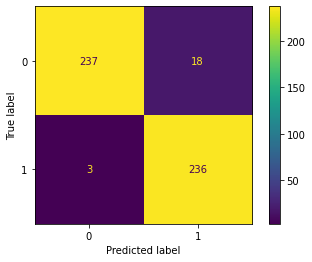

In [21]:
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
plot_cm(clf, X_test, y_test)

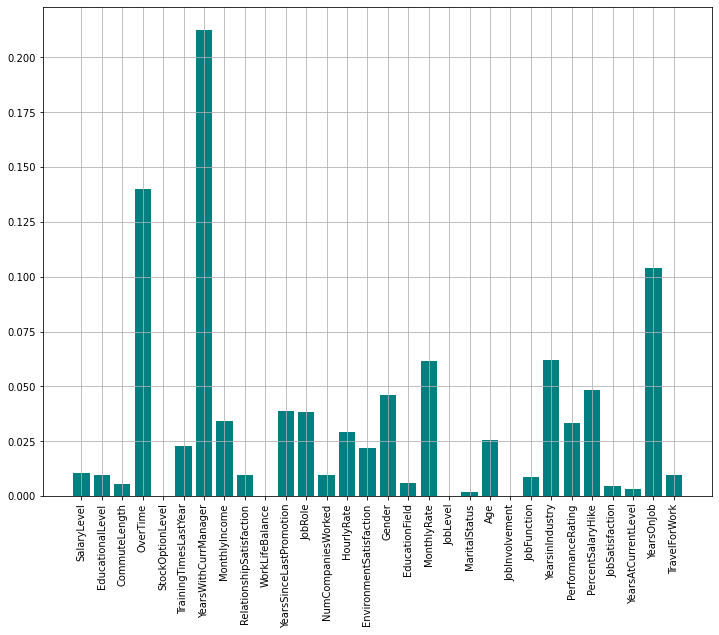

In [22]:
plt.figure(figsize=(12,9))
plt.bar(x=features, height=clf.feature_importances_)
plt.xticks(rotation=90)
plt.grid(True)
plt.show();